In [22]:
import sys
!{sys.executable} -m pip install utm
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tqdm

    100% |████████████████████████████████| 51kB 3.3MB/s ta 0:00:01


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

In [1]:
import osmnx as ox
%matplotlib inline
G = ox.graph_from_place('Porto, Portugal', network_type='drive', which_result=2)

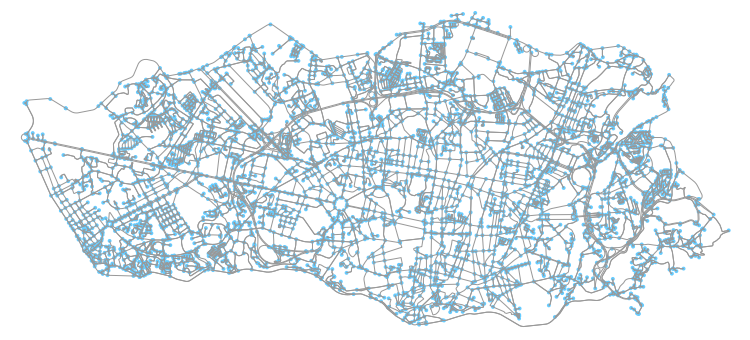

In [2]:
G = ox.projection.project_graph(G)
fig, ax = ox.plot_graph(ox.project_graph(G))

In [3]:
class TaxiDataset:
	def __init__(self, location, coords, timestamps):
		self.location = location
		self.coords = coords
		self.timestamps = timestamps

In [19]:
import pandas as pd
import utm

def to_utm(long, lat):
    x, y, _, _ = utm.from_latlon(lat, long)
    return (x, y)

def fetch_taxi_dataset(location='manhattan', date='2016-01'):
    """
    Downloads and caches the taxi dataset for the given location (and date for NYC).
    """
    if location == 'manhattan':
        filename = 'yellow_tripdata_' + date + '.csv'
        filename = 'test.csv'
        filepath = 'data/' + location + '/' + filename

    #     if not os.path.exists(filepath):
    #         urllib.request.urlretrieve('https://s3.amazonaws.com/nyc-tlc/trip+data/' + filename, filepath)

        df = pd.read_csv(filepath, usecols=['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude'])
        return TaxiDataset(location, 
                           list(map(lambda x: to_utm(*x), zip(df['pickup_longitude'], df['pickup_latitude']))), 
                           df['tpep_pickup_datetime'])
    
    elif location == 'porto':
        filename = 'train.csv'
        filepath = 'data/' + location + '/' + filename
        
        
        df = pd.read_csv(filepath, usecols=['TIMESTAMP', 'POLYLINE'])
        coords = []
        timestamps = []
        for ts, line in tqdm(zip(df['TIMESTAMP'], df['POLYLINE'])):
            end = line.index(']')
            raw_coords = line[:end].split(',')
            if len(raw_coords) < 2:
                continue
            timestamps.append(int(ts))
            long = float(raw_coords[0][2:])
            lat = float(raw_coords[1])
            coords.append(to_utm(long, lat))
        return TaxiDataset(location, coords, timestamps)

td = fetch_taxi_dataset('porto')

In [20]:
from sklearn.neighbors import KDTree

tp = np.array(td.coords[1])
nodes, _ = ox.graph_to_gdfs(G)
kd = KDTree(nodes[['x', 'y']], metric='euclidean')

idx = kd.query([tp], k=1, return_distance=False)[0]
closest_node = nodes.iloc[idx].index.values[0]
print(tp, (G.node[closest_node]['x'], G.node[closest_node]['y']))

[ 530216.16048058 4556562.01527464] (530233.8468610734, 4556549.776800515)


In [28]:
project_count = defaultdict(int)
for p in tqdm(td.coords[:100000]):
    idx = kd.query([p], k=1, return_distance=False)[0]
    closest_node = nodes.iloc[idx].index.values[0]
    project_count[closest_node] += 1


 28%|██▊       | 27548/100000 [00:14<00:46, 1569.53it/s]


 54%|█████▍    | 54165/100000 [00:29<00:23, 1974.32it/s]


 83%|████████▎ | 82821/100000 [00:43<00:07, 2176.60it/s]


100%|██████████| 100000/100000 [00:51<00:00, 1923.42it/s]

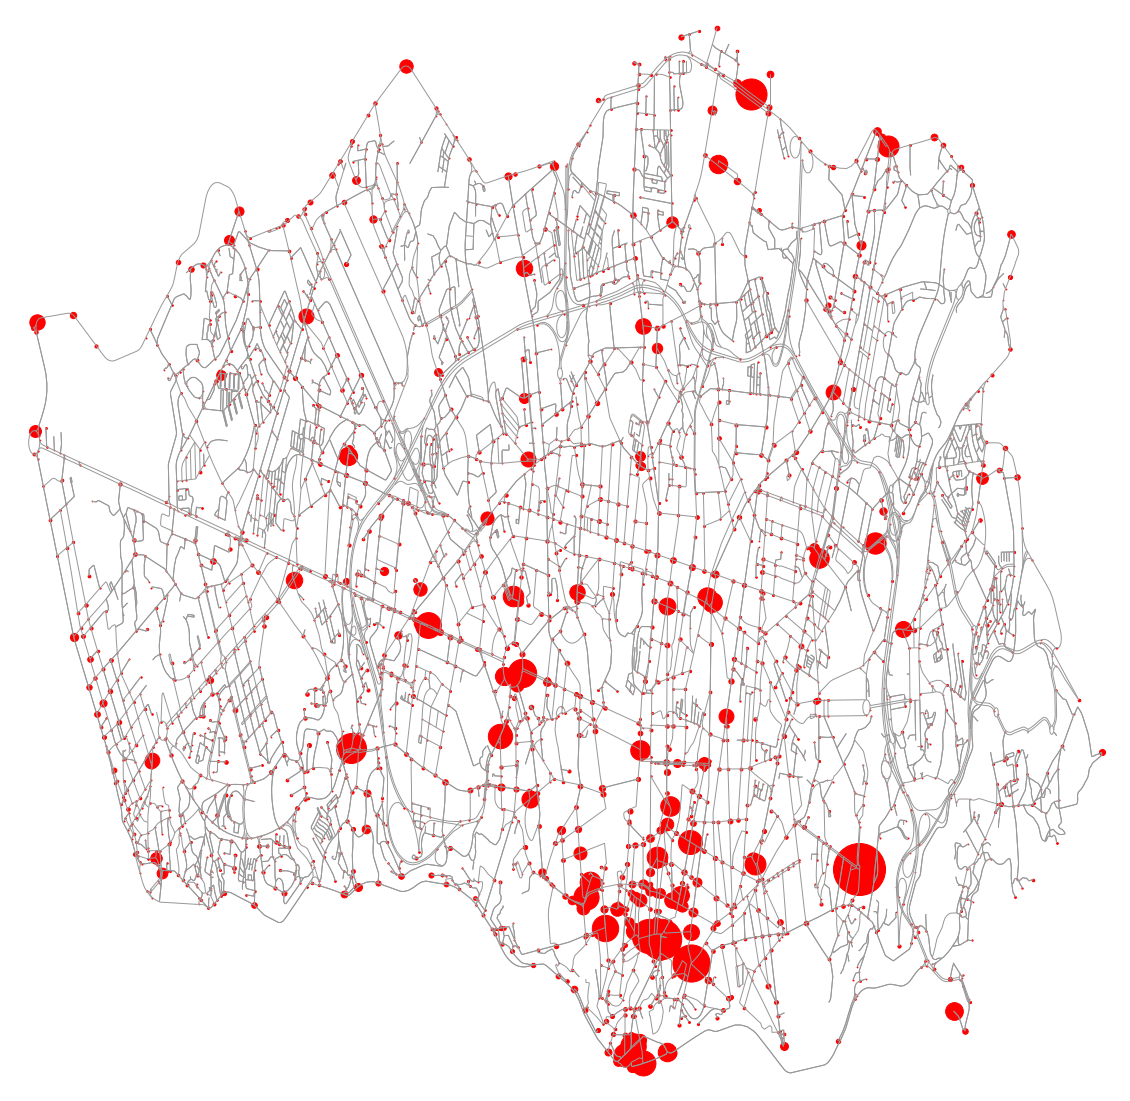

In [31]:
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0,
                        fig_height=20, fig_width=20)

for id, val in project_count.items():
    ax.scatter(G.node[id]['x'], G.node[id]['y'], c='red', s=0.5 * val)
    
plt.show()

6.865760992292401e-07


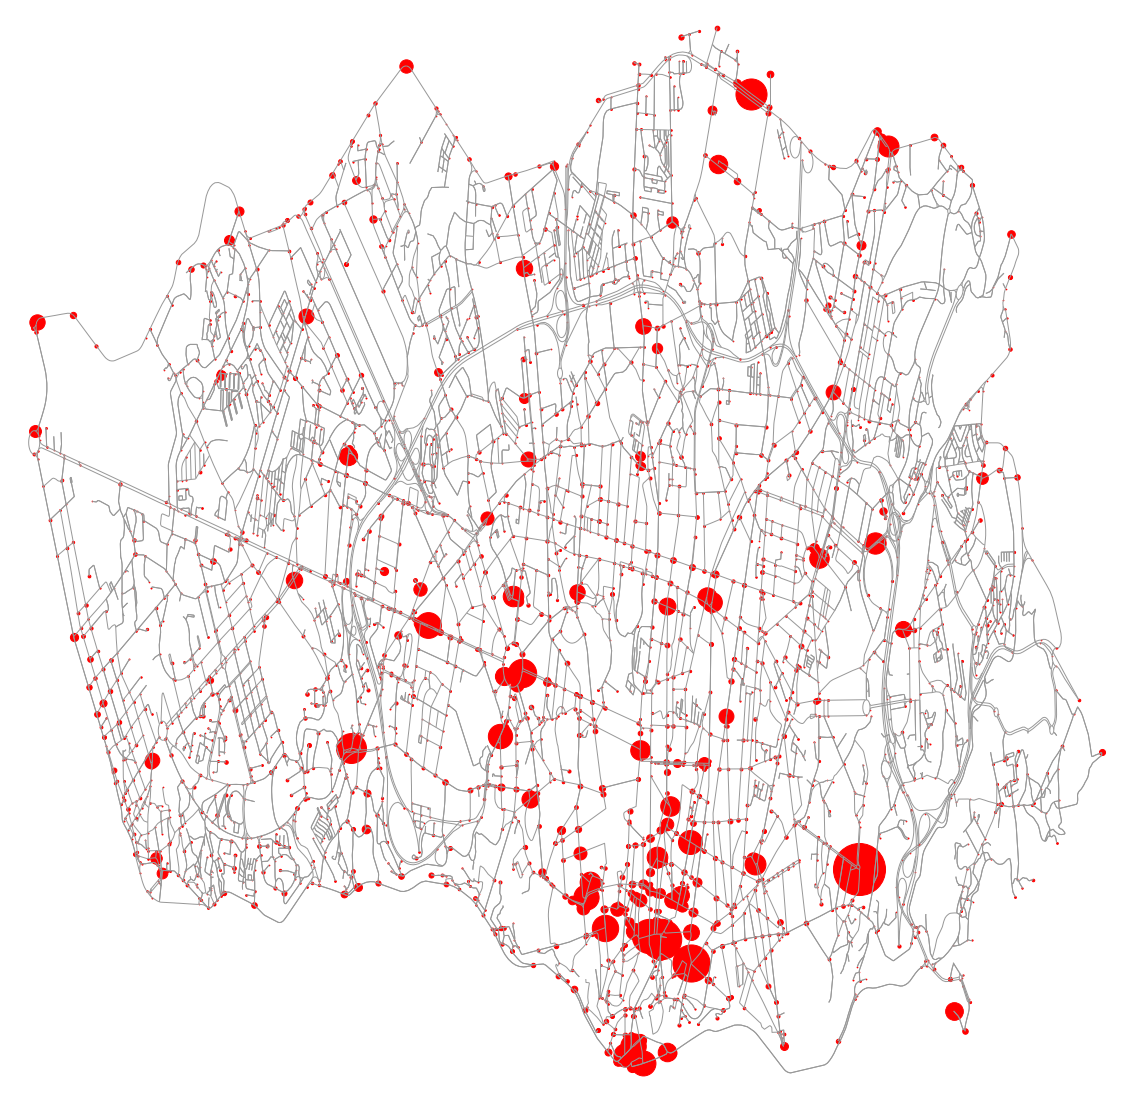

In [32]:
dp_eps = 0.001

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0,
                        fig_height=20, fig_width=20)

error = 0.
count = 0

for id, val in project_count.items():
    lap = np.random.laplace(0, 1. / (dp_eps * len(td.coords)))
    val += lap
    ax.scatter(G.node[id]['x'], G.node[id]['y'], c='red', s=0.5 * val)
    error += lap **2
    count += 1

print(error / count)

plt.show()

In [33]:
from scipy.special import lambertw

def sample_laplacian2d(x_0, eps):
    theta = np.random.uniform(0, 2 * np.pi)
    p = np.random.uniform(0, 1)
    r = (-1. / eps) * (lambertw((p-1) / np.e, k=-1) + 1)

    return np.real(np.array([x_0]) + [r * np.sin(theta), r * np.cos(theta)])

sample_laplacian2d((5,6), 0.1)


array([[54.71320251, 16.70068653]])

In [ ]:
obfus_project_count = defaultdict(int)

for p in td.coords:
    p = sample_laplacian2d(p, 0.01)
    idx = kd.query(p, k=1, return_distance=False)[0]
    closest_node = nodes.iloc[idx].index.values[0]
    obfus_project_count[closest_node] += 1
    
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0,
                        fig_height=20, fig_width=20)

error = 0.
count = 0.
for id, val in obfus_project_count.items():
    error += (obfus_project_count[id] - project_count[id]) ** 2
    count += 1
    ax.scatter(G.node[id]['x'], G.node[id]['y'], c='red', s=5 * val)

print(error / count)

plt.show()